In [1]:
import pdb
import numpy as np
import random
import math
import argparse
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from shutil import copyfile
import scipy
from sklearn.model_selection import train_test_split

In [82]:
Maximum = 20
Minimum = -20

#### Make Data

In [83]:
# Train Period
def get_Sin_Seq_Data(timestep, count):
    # timestep: length of one seq
    # count: number of seqs
    
    X_Y_data = np.zeros(shape=(count,timestep,2))
    Period_data = np.zeros(shape=(count, 1))
    
    params = {}
    params['a'] = [] ; params['b'] = [] ; params['c'] = [] ; params['d'] = []
    
    for r in range(count):
        a = random.randint(1,6) ; b = random.uniform(0.12, 3)
        c = random.randint(1,6) ; d = random.randint(1,6)
        params['a'].append(a) ; params['b'].append(b)
        params['c'].append(c) ; params['d'].append(d)
        
        x_seq, y_seq = get_Sin_Data(count=timestep, a=a, b=b, c=c, d=d, Minimum=Minimum, Maximum=Maximum)
        X_Y_data[r] = np.concatenate((x_seq, y_seq), axis=1)
        Period_data[r] = 2 * math.pi / b
    
    return X_Y_data, Period_data, params

# Train Y value
def get_Sin_Data(count, a, b, c=0, d=0, Minimum=Minimum, Maximum=Maximum):
    #X_data = 2 * np.pi / b * cycle / count * np.arange(base, count)
    X_data = np.sort(np.random.uniform(Minimum, Maximum, size=(count,1)))
    Y_data = a * np.sin(b*X_data + c) + d
    
    return X_data, Y_data

#### Visualization

In [134]:
plt.rcParams.update({'font.size': 15})

In [97]:
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plotSinData(a, b, c, d):
    x = np.arange(Minimum, Maximum ,0.1)   # start,stop,step
    y = a* np.sin(b*x + c) +d
    plt.plot(x,y, 'y.--', alpha = 0.5)
    
def plotSeqData(X_Y_data, Period_data, params=None, count=3, model=None, title_name=None):
    X_Y_data = X_Y_data.copy()
    X_data = np.squeeze(X_Y_data[:,:,0]) # (count, timesteps)
    Y_data = np.squeeze(X_Y_data[:,:,1]) # (count, timesteps)
    
    sample = np.random.choice(X_data.shape[0], size=count, replace=False)
    print(sample)
    for r in sample:
        plt.figure(figsize=(10,5))
        x = np.squeeze(X_data[r]) # (timesteps,)
        y = np.squeeze(Y_data[r]) # (timesteps,)
        
        # plot original sign graph
        plotSinData(params['a'][r], params['b'][r], params['c'][r], params['d'][r])
        # plot data points
        plt.scatter(x, y, color='violet', label="data")
        plt.legend()
        if title_name is not None:
            plt.title(title_name)
        plt.show()
        
        print("Answer ", Period_data[r])
        if model is not None:
            # predict answer
            y_predict = model.predict(X_Y_data[r:r+1])
            print("model expects", y_predict)
    
def plotData(X_data, Y_data, data_period, params=None, model=None, title_name=None):
    plt.figure(figsize=(20,10))
    
    X_data = np.squeeze(X_data.copy())
    Y_data = np.squeeze(Y_data.copy())
    idx = np.argsort(X_data)
    X_data = X_data[idx]
    Y_data = Y_data[idx]
    
    print(params['a'], params['b'], params['c'], params['d'])
    plotSinData(params['a'], params['b'], params['c'], params['d'])
    
    plt.scatter(X_data, Y_data, color='violet', label="target")
        
    if model is not None:
        plt.scatter(X_data, model.predict(X_data%data_period), color='blue', label="output")
    plt.legend()
    if title_name is not None:
        plt.title(title_name)
    plt.show()

[4 2 1]


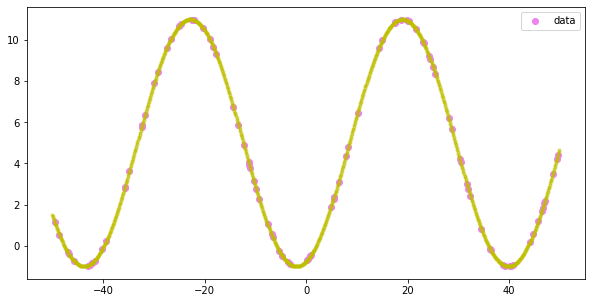

Answer  [41.77178454]


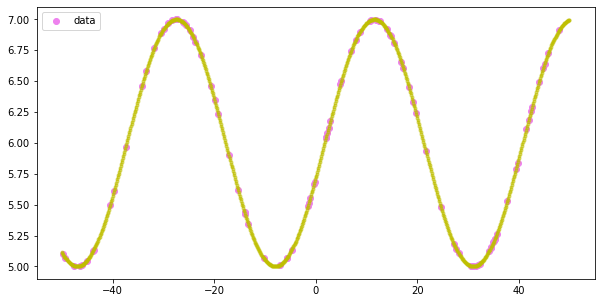

Answer  [39.0035548]


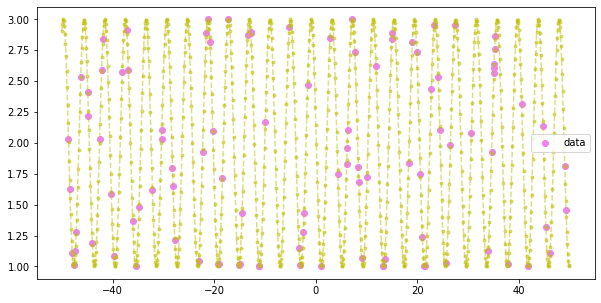

Answer  [4.06575605]


In [5]:
#test
x_y, p, params = get_Sin_Seq_Data(timestep=100, count=5)
plotSeqData(x_y, p, params=params)

#### Model

In [66]:
EPOCHS = 200
BATCH_SIZE = 20

In [84]:
def buildFCModel(input_shape, hidden_layers=4, hidden_neurons=128, lr=0.0002):
    model = tf.keras.Sequential()
    model.add(Dense(hidden_neurons, input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.03))
    
    for _ in range(hidden_layers):
        model.add(Dense(hidden_neurons, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(LeakyReLU(alpha=0.03))
    
    model.add(Dense(1))

    model.compile(loss='mse', optimizer=Adam(lr=lr))
    model.summary()
    
    board = TensorBoard(log_dir='model', histogram_freq=1, write_graph=True, write_images=False)
    board.set_model(model)
    
    return model, board

def buildLSTMModel(batch_input_shape, stack_size=1, output_dim=1, hidden_dim=128, lr=0.00002):
    # batch_input_shape = (batch_size, timesteps, input_dim)
    # lr = 0.0002
    model = tf.keras.Sequential()
    model.add(LSTM(hidden_dim, batch_input_shape=batch_input_shape, return_sequences=True, stateful=True))
    for _ in range(stack_size - 2):
        model.add(LSTM(hidden_dim, return_sequences=True, stateful=True))
    model.add(LSTM(hidden_dim, return_sequences=False, stateful=True))
    #model.add(Dropout(0.778)) # 0.77
    model.add(Dense(output_dim, kernel_regularizer=tf.keras.regularizers.l2(0.01))) # 0.0085
    model.add(LeakyReLU(alpha=0.03))
    
    opt = Adam(lr=lr, decay=lr/(EPOCHS*EPOCHS))
    model.compile(loss='mse', optimizer=opt)
    model.summary()

    board = TensorBoard(log_dir='model', histogram_freq=1, write_graph=True, write_images=False)
    board.set_model(model)
    return model, board

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=80)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [86]:
def Get_Result_From_FC(X_data, Y_data, data_period, params, batch_size=50, epochs=1000, mode="Train"):
    model = None
    
    if mode == "Train":
        X_train,X_test,Y_train,Y_test=train_test_split(X_data, Y_data, test_size=0.2)
        model, board = buildFCModel(input_shape=(1,))
        
        plotData(X_data, Y_data, data_period, params=params, model=model, title_name="Before Training")
        start = time()
        history=model.fit(X_train%data_period, Y_train, batch_size=50, epochs=epochs, validation_data=(X_test%data_period,Y_test), verbose=2, callbacks=[es, mc])
        #callbacks=[board]
        end = time()
        print("[ Time ]", end-start)
        plotLoss(history)
        
        plotData(X_data, Y_data, data_period, params=params, model=model, title_name="After Training") 
        
    return model

def Get_Result_From_LSTM(X_Y_data, Period_data, params, stack_size=1, batch_size=1, epochs=200):
    X_Y_train, X_Y_test, Period_train, Period_test = train_test_split(X_Y_data, Period_data, test_size=0.2)
    model, board = buildLSTMModel(batch_input_shape=(batch_size, X_Y_data.shape[1], X_Y_data.shape[2]), stack_size=stack_size)
    plotSeqData(X_Y_data, Period_data, params=params, model=model, title_name="Before Training")
    
    history=model.fit(X_Y_train, Period_train, batch_size=batch_size, epochs=epochs, validation_data=(X_Y_test,Period_test), callbacks=[es, mc])
    
    plotLoss(history)
    plotSeqData(X_Y_data, Period_data, params=params, model=model, title_name="After Training")
    
    return model    

[465 115 195]


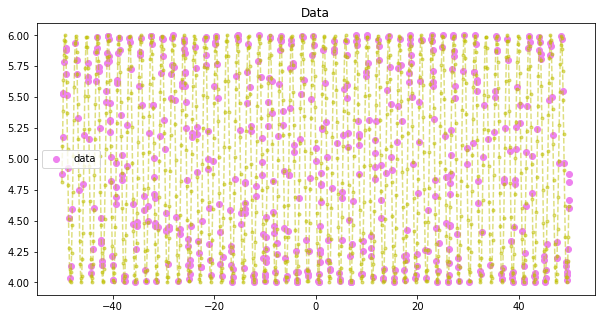

Answer  [2.12696726]


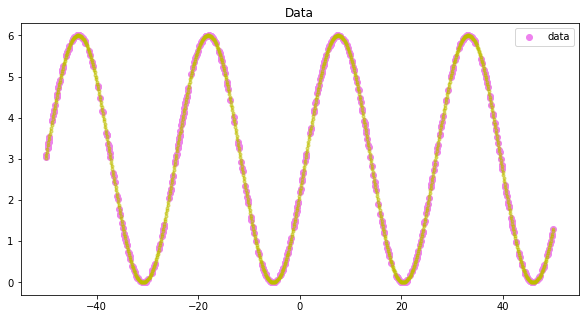

Answer  [25.59842684]


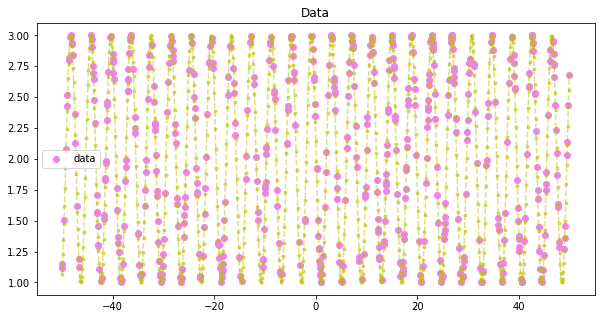

Answer  [3.94726045]
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (20, 600, 128)            67072     
_________________________________________________________________
lstm_71 (LSTM)               (20, 128)                 131584    
_________________________________________________________________
dense_20 (Dense)             (20, 1)                   129       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 108ms/step - loss: 98.3064 - val_loss: 114.4177
Epoch 2/200
20/20 [==============================] - 1s 72ms/step - loss: 94.8556 - val_loss: 109.1780
Epoch 3/200
20/20

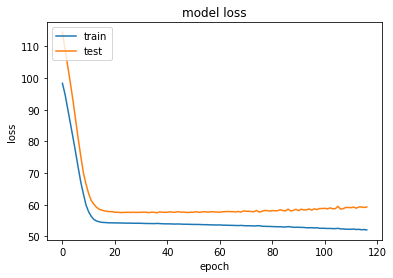

In [11]:
X_Y_data, Periods, params = get_Sin_Seq_Data(timestep=600, count=500)
plotSeqData(X_Y_data, Periods, params=params, model=None, title_name="Data")
X_Y_train, X_Y_test, Period_train, Period_test = train_test_split(X_Y_data, Periods, test_size=0.2)

model, board = buildLSTMModel(batch_input_shape=(BATCH_SIZE, X_Y_data.shape[1], X_Y_data.shape[2]), stack_size=2)
start = time()
history = model.fit(X_Y_train, Period_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_Y_test, Period_test), verbose=1, callbacks=[es, mc])
end = time()

print("time")
print(end-start)

plotLoss(history)

In [93]:
params={}

params['a'] = 1 ; params['b'] = random.uniform(0.12, 3); params['c'] = 0 ; params['d'] = 0

Minimum = -20; Maximum = 20

X_data, Y_data = get_Sin_Data(count=600, a=params['a'], b=params['b'], c=params['c'], d=params['d'])
print(params)
print("Real data period: ", round(2*math.pi/params['b'],2))

# x = np.expand_dims(X_data,axis=0)
x = np.tile(X_data, (BATCH_SIZE, 1, 1))
# y = np.expand_dims(Y_data,axis=0)
y = np.tile(Y_data, (BATCH_SIZE, 1, 1))

data = np.concatenate((x,y), axis=2)
data_period = model.predict(data)[0]

print("predicted period: ", data_period)

{'a': 1, 'b': 1.3436360005678867, 'c': 0, 'd': 0}
Real data period:  4.68
predicted period:  [4.7686667]


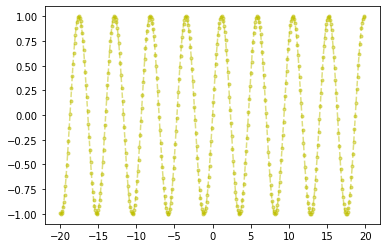

In [94]:
plotSinData(params['a'], params['b'], params['c'], params['d'])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 128)               256       
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 128)             

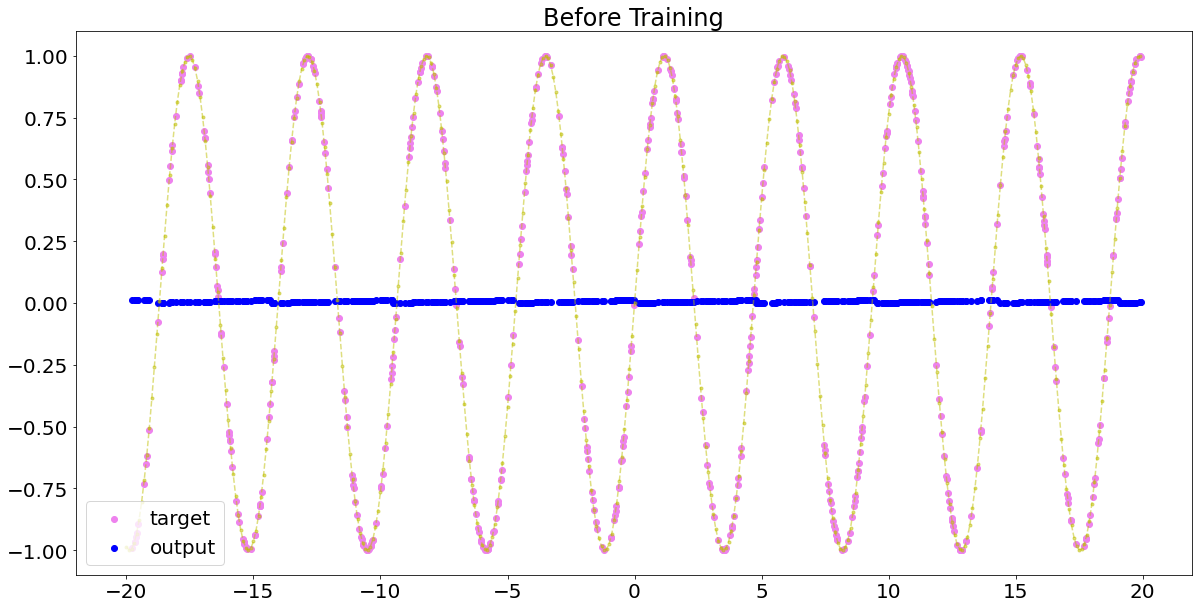

Epoch 1/1000
10/10 - 0s - loss: 5.5887 - val_loss: 5.4555
Epoch 2/1000
10/10 - 0s - loss: 5.3630 - val_loss: 5.2859
Epoch 3/1000
10/10 - 0s - loss: 5.1715 - val_loss: 5.0896
Epoch 4/1000
10/10 - 0s - loss: 4.9830 - val_loss: 4.8995
Epoch 5/1000
10/10 - 0s - loss: 4.8003 - val_loss: 4.7259
Epoch 6/1000
10/10 - 0s - loss: 4.6248 - val_loss: 4.5534
Epoch 7/1000
10/10 - 0s - loss: 4.4515 - val_loss: 4.3819
Epoch 8/1000
10/10 - 0s - loss: 4.2864 - val_loss: 4.2206
Epoch 9/1000
10/10 - 0s - loss: 4.1239 - val_loss: 4.0650
Epoch 10/1000
10/10 - 0s - loss: 3.9646 - val_loss: 3.9078
Epoch 11/1000
10/10 - 0s - loss: 3.8149 - val_loss: 3.7638
Epoch 12/1000
10/10 - 0s - loss: 3.6690 - val_loss: 3.6235
Epoch 13/1000
10/10 - 0s - loss: 3.5310 - val_loss: 3.4872
Epoch 14/1000
10/10 - 0s - loss: 3.3979 - val_loss: 3.3570
Epoch 15/1000
10/10 - 0s - loss: 3.2728 - val_loss: 3.2505
Epoch 16/1000
10/10 - 0s - loss: 3.1533 - val_loss: 3.1290
Epoch 17/1000
10/10 - 0s - loss: 3.0421 - val_loss: 3.0235
Epoch 

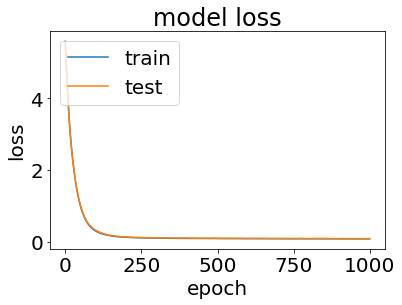

1 1.3436360005678867 0 0


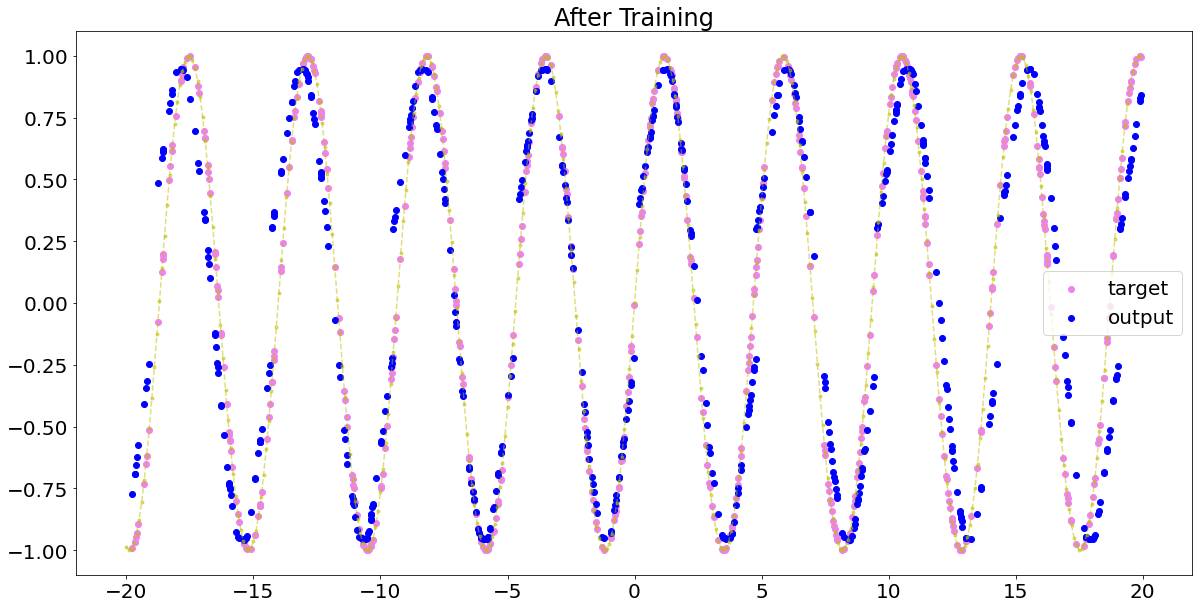

In [98]:
FC_model = Get_Result_From_FC(X_data, Y_data, data_period=data_period, params=params, mode="Train")

### Experiment

[215  26  90]


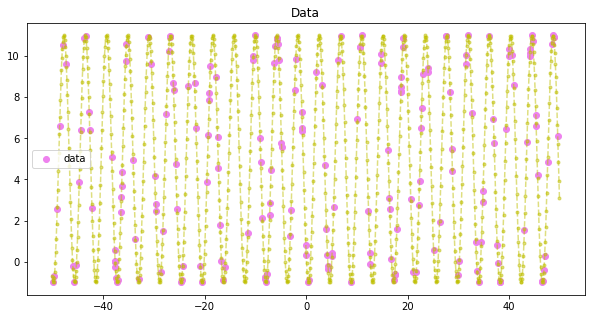

Answer  [4.18790069]


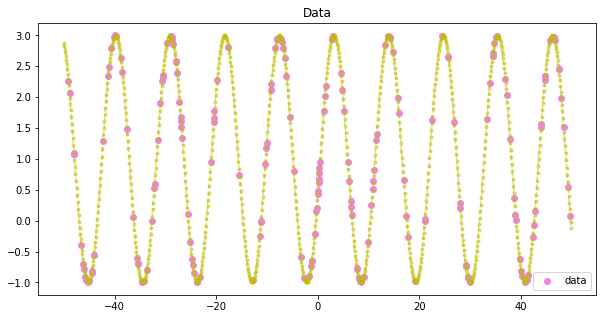

Answer  [10.754412]


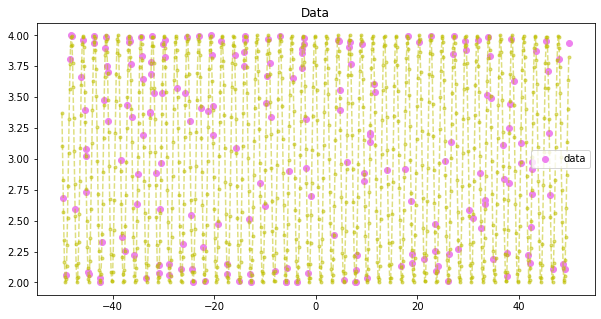

Answer  [2.28529041]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 200, 128)            67072     
_________________________________________________________________
lstm_1 (LSTM)                (20, 128)                 131584    
_________________________________________________________________
dense (Dense)                (20, 1)                   129       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 1s 66ms/step - loss: 108.5581 - val_loss: 87.8021
Epoch 2/200
20/20 [==============================] - 1s 28ms/step - loss: 104.6529 - val_loss: 83.9050
Epoch 3/200
20/20 [==

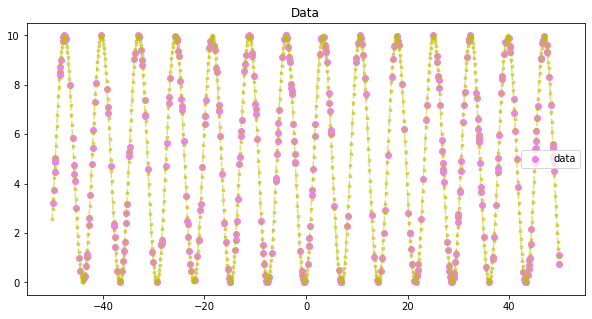

Answer  [7.27166511]


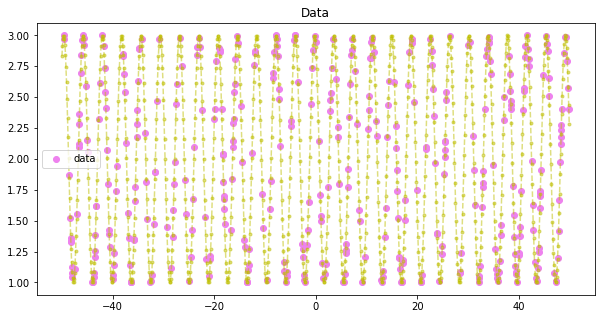

Answer  [3.79877961]


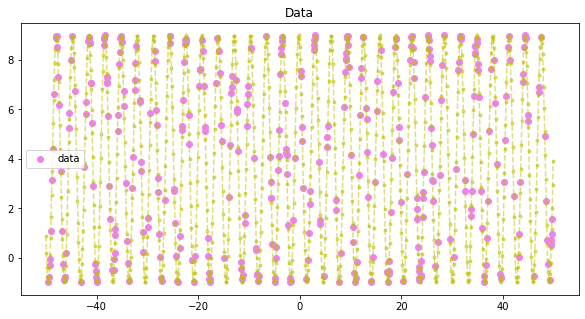

Answer  [3.1824756]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (20, 400, 128)            67072     
_________________________________________________________________
lstm_15 (LSTM)               (20, 128)                 131584    
_________________________________________________________________
dense_4 (Dense)              (20, 1)                   129       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 82ms/step - loss: 94.6111 - val_loss: 94.1032
Epoch 2/200
20/20 [==============================] - 1s 48ms/step - loss: 92.9021 - val_loss: 90.6918
Epoch 3/200
20/20 [===

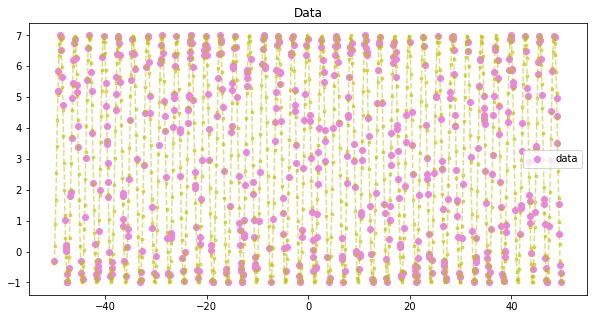

Answer  [2.86091102]


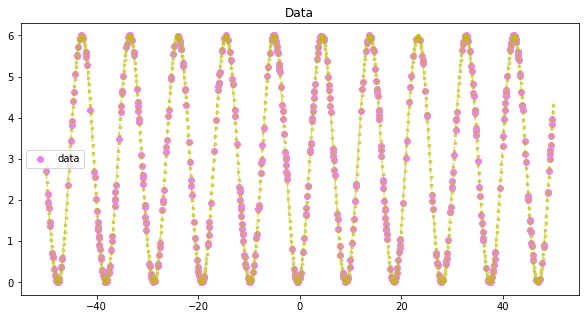

Answer  [9.45707536]


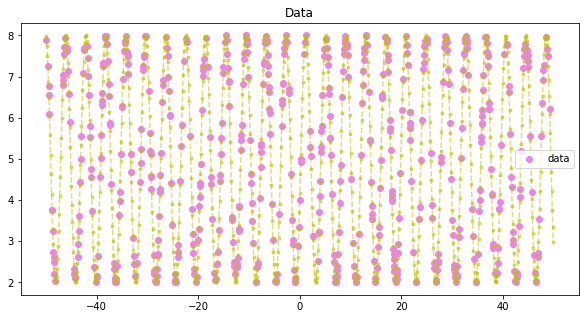

Answer  [3.9405508]
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (20, 600, 128)            67072     
_________________________________________________________________
lstm_29 (LSTM)               (20, 128)                 131584    
_________________________________________________________________
dense_8 (Dense)              (20, 1)                   129       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 107ms/step - loss: 129.2778 - val_loss: 108.4347
Epoch 2/200
20/20 [==============================] - 1s 71ms/step - loss: 125.3724 - val_loss: 103.7892
Epoch 3/200
20/20

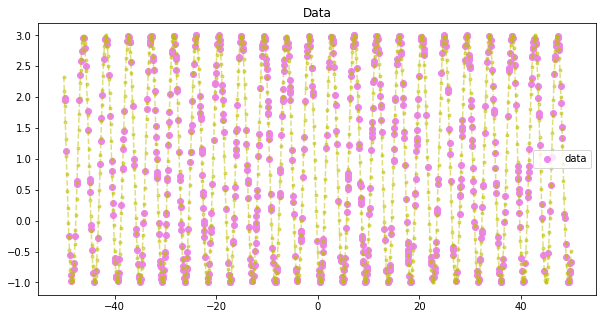

Answer  [4.44354191]


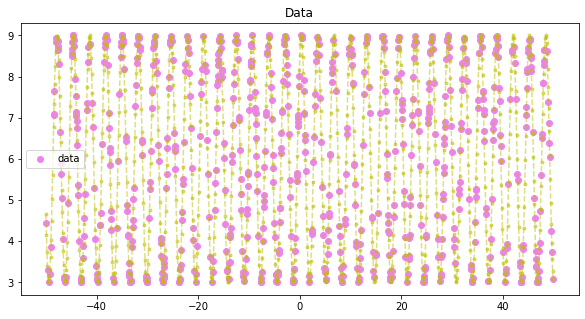

Answer  [3.20815256]


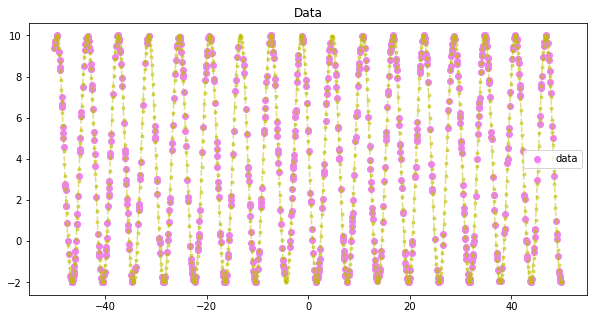

Answer  [6.02146496]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (20, 800, 128)            67072     
_________________________________________________________________
lstm_43 (LSTM)               (20, 128)                 131584    
_________________________________________________________________
dense_12 (Dense)             (20, 1)                   129       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 124ms/step - loss: 83.3502 - val_loss: 96.4770
Epoch 2/200
20/20 [==============================] - 2s 92ms/step - loss: 79.4209 - val_loss: 92.3392
Epoch 3/200
20/20 [

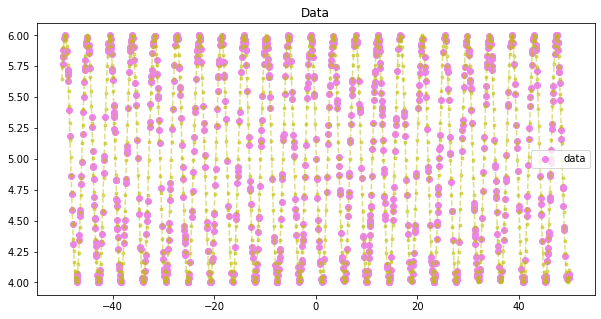

Answer  [4.3991294]


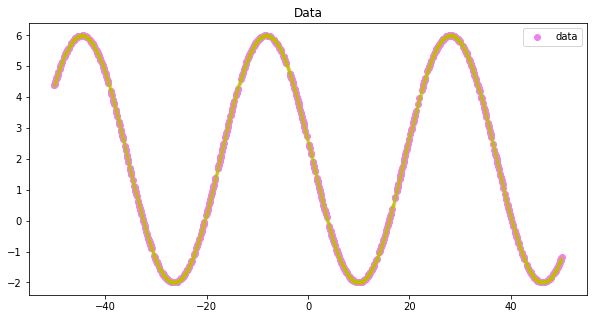

Answer  [36.33539947]


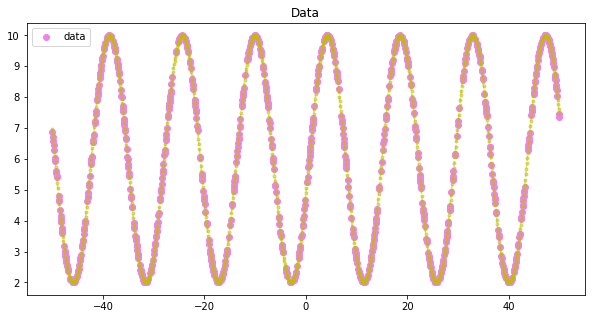

Answer  [14.31307755]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (20, 1000, 128)           67072     
_________________________________________________________________
lstm_57 (LSTM)               (20, 128)                 131584    
_________________________________________________________________
dense_16 (Dense)             (20, 1)                   129       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (20, 1)                   0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 3s 146ms/step - loss: 125.1909 - val_loss: 93.1477
Epoch 2/200
20/20 [==============================] - 2s 112ms/step - loss: 121.2273 - val_loss: 89.0303
Epoch 3/200
20/

In [10]:
from time import time
import csv

with open('LSTM_Architecture_Search.csv','w', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['stack_size','timesteps', 'loss', 'time'])
    
    for i in range(200,1001,200):
        X_Y_data, Periods, params = get_Sin_Seq_Data(timestep=i, count=500)
        plotSeqData(X_Y_data, Periods, params=params, model=None, title_name="Data")
        X_Y_train, X_Y_test, Period_train, Period_test = train_test_split(X_Y_data, Periods, test_size=0.2)

        for s in range(2,6):
            model, board = buildLSTMModel(batch_input_shape=(BATCH_SIZE, X_Y_data.shape[1], X_Y_data.shape[2]), stack_size=s)
            start = time()
            history = model.fit(X_Y_train, Period_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_Y_test, Period_test), verbose=1, callbacks=[es, mc])
            end = time()
            accuracy = history.history['val_loss'][-1]
            
            wr.writerow([s, i, accuracy, end-start])

#### Test Model: [-500, 500) 범위에서 100개 데이터를 뽑아서 테스트

In [ ]:
params={}
params['a'] = 1 ; params['b'] = random.uniform(0.12, 3) ; params['c'] = 0 ; params['d'] = 0

Minimum = -100; Maximum = 100

X_Testdata, Y_Testdata = get_Sin_Data(count=100, a=params['a'], b=params['b'], c=params['c'], d=params['d'])
plotData(X_Testdata, Y_Testdata, data_period = data_period ,params=params, model=FC_model, title_name="Test Model")

### Visualize Result

In [99]:
import pandas as pd
result = pd.read_csv('./LSTM_Architecture_Search.csv') # 'stack_size','timesteps', 'loss'
print(result)

    stack_size  timesteps       loss        time
0            2        200  47.620636   66.321358
1            3        200  49.177784   81.500187
2            4        200  47.791447  106.723160
3            5        200  50.665096  130.774946
4            2        400  50.066513  105.657523
5            3        400  49.849369  153.275860
6            4        400  50.500923  207.091187
7            5        400  49.669609  282.506617
8            2        600  59.497402  145.644790
9            3        600  59.073429  446.014625
10           4        600  60.273869  273.295792
11           5        600  67.026848  733.276132
12           2        800  57.822010  197.497238
13           3        800  57.541428  287.366477
14           4        800  57.696144  470.765989
15           5        800  61.031944  942.023553
16           2       1000  53.572704  229.032260
17           3       1000  54.934414  319.398727
18           4       1000  56.352829  413.360887
19           5      

In [114]:
result_time = result['time'].groupby([result['stack_size'], result['timesteps']]).mean()
result_time = result_time.unstack()
result_time

timesteps,200,400,600,800,1000
stack_size,,,,,
2,66.321358,105.657523,145.644790,197.497238,229.032260
3,81.500187,153.275860,446.014625,287.366477,319.398727
4,106.723160,207.091187,273.295792,470.765989,413.360887
5,130.774946,282.506617,733.276132,942.023553,522.012760


In [139]:
plt.rcParams.update({'font.size': 13})

In [140]:
timestep = [200, 400, 600, 800, 1000]
stack_size = [2,3,4,5]

timesteps
200     130.774946
400     282.506617
600     733.276132
800     942.023553
1000    522.012760
Name: 5, dtype: float64


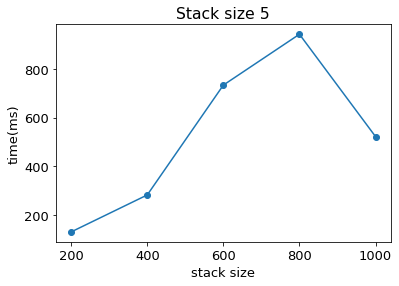

In [152]:
i = 0 ; j = 3
print(result_time.iloc(i)[j])

plt.plot(result_time.iloc(i)[j], '-o')
plt.ylabel('time(ms)')
plt.xlabel('stack size')
plt.title("Stack size " + str(stack_size[j]))
plt.show()

In [153]:
loss_result = result['loss'].groupby([result['stack_size'],result['timesteps']]).mean()
loss_result = loss_result.unstack()
loss_result

timesteps,200,400,600,800,1000
stack_size,,,,,
2,47.620636,50.066513,59.497402,57.822010,53.572704
3,49.177784,49.849369,59.073429,57.541428,54.934414
4,47.791447,50.500923,60.273869,57.696144,56.352829
5,50.665096,49.669609,67.026848,61.031944,55.198681


In [154]:
loss_result.to_csv('lstm_loss_result.csv', encoding='utf-8', index=True)
loss_result = pd.read_csv('lstm_loss_result.csv')

In [156]:
print(loss_result)

   stack_size        200        400        600        800       1000
0           2  47.620636  50.066513  59.497402  57.822010  53.572704
1           3  49.177784  49.849369  59.073429  57.541428  54.934414
2           4  47.791447  50.500923  60.273869  57.696144  56.352829
3           5  50.665096  49.669609  67.026848  61.031944  55.198681


In [159]:
avg_loss_result = result['loss'].groupby(result['timesteps']).mean()
avg_loss_result.to_csv('lstm_avg_loss_result.csv', encoding='utf-8', index=True)
avg_loss_result = pd.read_csv('lstm_avg_loss_result.csv')

In [168]:
print(avg_loss_result)

   timesteps       loss
0        200  48.813741
1        400  50.021604
2        600  61.467887
3        800  58.522882
4       1000  55.014657


In [174]:
print(avg_loss_result['loss'])

0    48.813741
1    50.021604
2    61.467887
3    58.522882
4    55.014657
Name: loss, dtype: float64


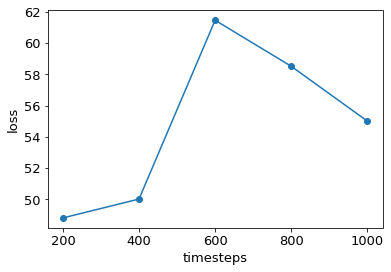

In [179]:
plt.plot(timestep, avg_loss_result['loss'], '-o')
plt.ylabel('loss')
plt.xlabel('timesteps')
plt.show()

## Plot

In [180]:
loss_result

,stack_size,200,400,600,800,1000
0,2,47.620636,50.066513,59.497402,57.822010,53.572704
1,3,49.177784,49.849369,59.073429,57.541428,54.934414
2,4,47.791447,50.500923,60.273869,57.696144,56.352829
3,5,50.665096,49.669609,67.026848,61.031944,55.198681


In [161]:
stack_size = [2,3,4,5]
timesteps = [200, 400, 600, 800, 1000]

In [162]:
plt.rcParams.update({'font.size': 13})

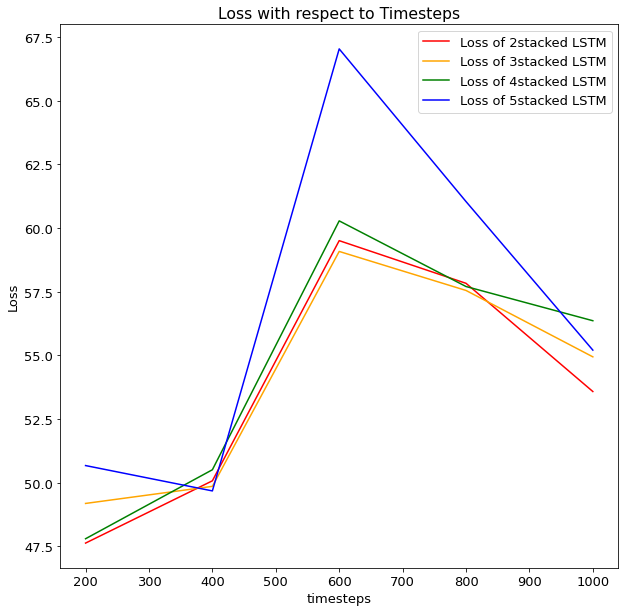

In [185]:
plt.figure(figsize=(10,10))

loss = {}
color = ['red', 'orange', 'green', 'blue']

for l in range(len(stack_size)):
    loss_data = []
    
    for n in range(len(timesteps)):
        loss_data.append(loss_result.loc[l][n+1])
    
    plt.plot(timesteps, loss_data, color=color[l], label="Loss of " + str(stack_size[l]) + "stacked LSTM")
    plt.xlabel("timesteps")
    plt.ylabel("Loss")
    
plt.legend()
plt.title("Loss with respect to Timesteps" )
    
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(20, 13))

loss = {}
color = ['red', 'orange', 'green', 'blue']
loss_data = []

for l in range(len(stack_size)):
    loss = 0
    for n in range(len(timesteps)):
        loss += (loss_result.loc[l][n+1])
    loss / 4
    loss_data.append(loss)
    
plt.plot(timesteps, loss_data, color='red', label="Average Loss of models")
plt.xlabel("timesteps")
plt.ylabel("Average of Loss")
    
plt.legend()
plt.title("Average Loss - the Number of Timesteps" )
    
plt.show()
plt.close()